# Fraud Detection in Card Portfolio Transactions

## Abstract

This project presents a comprehensive fraud detection framework for identifying suspicious activity within a card transactions portfolio. Developed for a consulting context, it combines both domain expertise and data science rigor to address the practical challenge of minimizing financial fraud while maintaining operational efficiency.

The analysis begins with a structured exploratory assessment of transaction-level data, highlighting key variables such as transaction amount, card presence, e-commerce activity, 3D Secure usage, and wallet types. A set of interpretable, business-driven fraud rules is then designed based on industry heuristics, forming the baseline for a rule-based fraud alert system.

To improve detection performance, a logistic regression model is developed using carefully selected features, offering a balance between predictive power and interpretability. Model outputs are benchmarked against the rule-based system using a set of custom KPIs relevant to the banking sector — including detection rate, false positive rate, and traditional classification metrics.

Throughout the notebook, special attention is given to interpretability, business relevance, and actionable insights. The dual-model approach not only demonstrates technical competence but also reflects a strategic consulting mindset: combining expert knowledge with data-driven optimization to create solutions that are both effective and trusted by business stakeholders.

## Imports

In [ ]:
import numpy as np
import pandas as pd

import scipy as sp
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from src.LoggerClass import FraudRuleLogger

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
import warnings
from sklearn.exceptions import ConvergenceWarning

import streamlit as st

## View Data

In [ ]:
# Load Dataset
df = pd.read_csv("data.csv")

In [70]:
# View Data
df.head()

,drn,customer_id,masked_pan,datetime,card_present,ecommerce,3ds,wallet,country,amount,card_type,fraud_label
0,TXN0000000,CUST015795,**** **** **** 6612,2024-03-04 03:56:41,0,0,0,NaN,CN,215.16,debit,0
1,TXN0000001,CUST000860,**** **** **** 0951,2023-11-22 14:50:25,1,0,0,NaN,IE,54.96,credit,0
2,TXN0000002,CUST005390,**** **** **** 6677,2023-11-05 20:33:30,0,1,0,NaN,FR,111.66,debit,0
3,TXN0000003,CUST011964,**** **** **** 0120,2024-03-23 23:52:32,0,1,1,Google Pay,US,28.62,debit,0
4,TXN0000004,CUST011284,**** **** **** 2698,2023-12-24 09:43:46,1,0,0,NaN,PL,71.40,debit,0


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134560 entries, 0 to 134559
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   drn           134560 non-null  object 
 1   customer_id   134560 non-null  object 
 2   masked_pan    134560 non-null  object 
 3   datetime      134560 non-null  object 
 4   card_present  134560 non-null  int64  
 5   ecommerce     134560 non-null  int64  
 6   3ds           134560 non-null  int64  
 7   wallet        46054 non-null   object 
 8   country       134560 non-null  object 
 9   amount        134560 non-null  float64
 10  card_type     134560 non-null  object 
 11  fraud_label   134560 non-null  int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 12.3+ MB


In [72]:
# Convert to datetime if not already
df['datetime'] = pd.to_datetime(df['datetime'])

- **drn -- *Object/String*** -- A Transaction Identification Number
- **castomer_id -- *Categorical Variable/String*** -- A unique masked Customer Identification Number
- **masked_pan -- *Categorical Variable/String*** - A card identification number
- **datetime -- *Temporal Variable/Date*** -- The exact date and time a transation took place
- **card_present -- *Categorical Variable/Int*** -- If the card is present during the transaction
- **ecommerce -- *Categorical Variable/Bool*** -- If the transaction is ecommerce
- **3ds -- *Categorical Variable/Bool*** -- If it is secured or not 
- **wallet -- *Categorical Variable/String*** -- If it utilizes Apple Pay, Google Pay or not
- **country -- *Categorical Variable/String*** -- The country that the transaction took place
- **amount -- *Numerical Variable/Float*** -- The amount of transaction 
- **card_type -- *Categorical Variable/String*** -- Either the card type used in a transaction was debit, credit or prepaid card
- **fraud label -- *Categorical Variable/Int*** -- Either the transaction is fraudulent or not

In [73]:
df.describe()

,datetime,card_present,ecommerce,3ds,amount,fraud_label
count,134560,134560.000000,134560.000000,134560.000000,134560.000000,134560.000000
mean,2024-02-18 16:28:09.263636992,0.447689,0.399859,0.276278,63.134685,0.003144
min,2023-11-01 00:02:39,0.000000,0.000000,0.000000,0.570000,0.000000
25%,2023-12-31 20:28:12.500000,0.000000,0.000000,0.000000,19.430000,0.000000
50%,2024-02-19 15:19:40,0.000000,0.000000,0.000000,44.800000,0.000000
75%,2024-04-08 14:00:47,1.000000,1.000000,1.000000,82.090000,0.000000
max,2024-06-28 00:00:00,1.000000,1.000000,1.000000,2979.320000,1.000000
std,NaN,0.497258,0.489871,0.447158,69.480347,0.055980


| Feature        | Type            | Key Insight                                                              |
|----------------|------------------|---------------------------------------------------------------------------|
| `card_present` | Binary           | ~44% are card-present transactions                                       |
| `ecommerce`    | Binary           | ~39% are ecommerce transactions                                        |
| `3ds`          | Binary           | ~25% of transactions used 3D Secure                                    |
| `amount`       | Continuous       | Avg ~64; wide spread (std ~73.37), max close to 3,000                 |
| `fraud_label`  | Binary (target)  | Highly imbalanced (0.27% fraud rate)                                    |

## Exploratory Data Analysis (EDA)

### Nulls and Duplicates

In [74]:
# Shape of the Data
# The shape of the DataFrame gives us the number of rows and columns in the dataset.
print(f"The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

The dataset contains 134560 rows and 12 columns.


In [75]:
# Detect null values
df.isnull().sum()

drn                 0
customer_id         0
masked_pan          0
datetime            0
card_present        0
ecommerce           0
3ds                 0
wallet          88506
country             0
amount              0
card_type           0
fraud_label         0
dtype: int64

***wallet*** column has null values. This is natural since not all transactions are using a digital wallet i.e. Apple Pay, Android Pay etc.

In [76]:
# Detect duplicate values
df[df.duplicated()]

,drn,customer_id,masked_pan,datetime,card_present,ecommerce,3ds,wallet,country,amount,card_type,fraud_label


It appears the synthetic dataset has not duplicate values.

### Numerical Variable Analysis

In [77]:
def plot_numerical_analysis(df, num_cols, target_col='fraud_label', bins=30):
    """
    Plots histogram, boxplot, and fraud rate per bin for each numerical column.
    """
    for col in num_cols:

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        sns.histplot(df[col], kde=True, bins=bins, ax=axes[0])
        axes[0].set_title(f"Histogram of {col}")

        sns.boxplot(x=df[col], ax=axes[1])
        axes[1].set_title(f"Boxplot of {col}")
        plt.tight_layout()
        plt.show()

        # Fraud rate by amount bins
        df['bin'] = pd.qcut(df[col], q=10, duplicates='drop')
        fraud_rate = df.groupby('bin')[target_col].mean().reset_index()
        fraud_rate.columns = [col + '_bin', 'fraud_rate']
        sns.barplot(data=fraud_rate, x=col + '_bin', y='fraud_rate')
        plt.xticks(rotation=45, ha='right')
        plt.title(f'Fraud Rate by {col} Bins')
        plt.tight_layout()
        plt.show()

        df.drop(columns='bin', inplace=True)

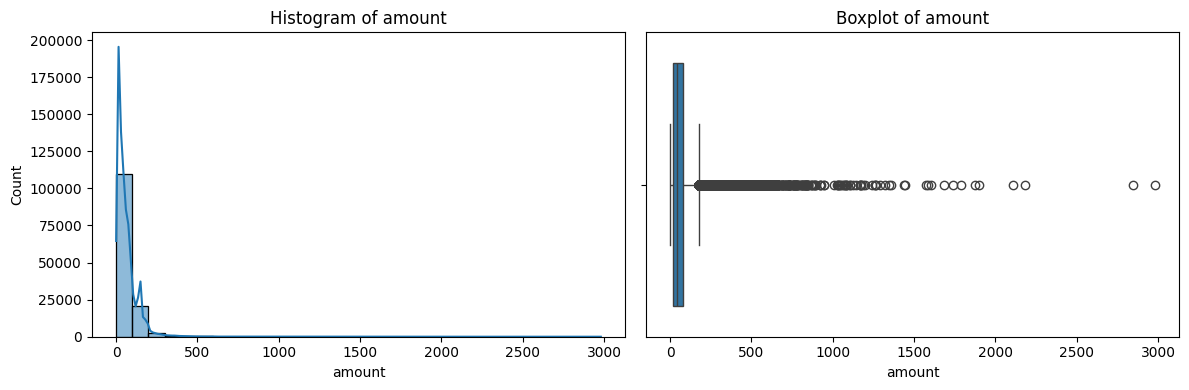

C:\Users\HA432CU\AppData\Local\Temp\ipykernel_33772\3085391368.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate = df.groupby('bin')[target_col].mean().reset_index()


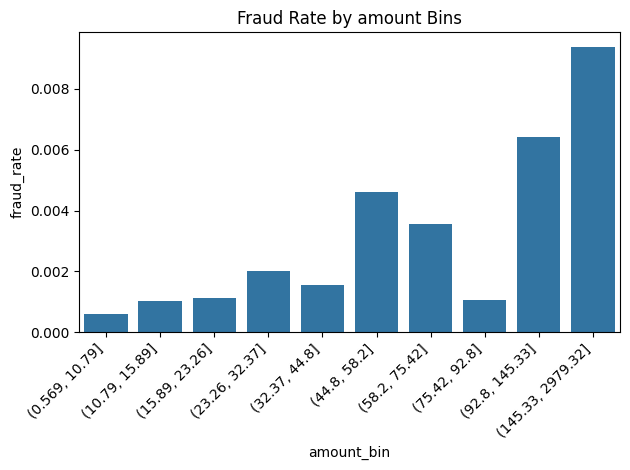

In [78]:
plot_numerical_analysis(df, num_cols=['amount'])

# int bins - mipws den valw bins

### Categorical Variable Analysis

In [79]:
def plot_categorical_vs_fraud(df, cat_cols, target_col='fraud_label', top_n=10):
    """
    Plots count and fraud rate for each categorical feature.
    """
    for col in cat_cols:

        # If high cardinality, limit to top N
        if df[col].nunique() > top_n:
            top_categories = df[col].value_counts().nlargest(top_n).index
            data = df[df[col].isin(top_categories)].copy()
        else:
            data = df.copy()

        # Countplot
        plt.figure(figsize=(8, 4))
        sns.countplot(data=data, x=col, order=data[col].value_counts().index)
        plt.title(f"Distribution of {col}")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # Fraud rate per category
        fraud_rate = data.groupby(col)[target_col].mean().reset_index()
        plt.figure(figsize=(8, 4))
        sns.barplot(data=fraud_rate, x=col, y=target_col, order=fraud_rate[col])
        plt.title(f"Fraud Rate by {col}")
        plt.ylabel("Fraud Rate")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

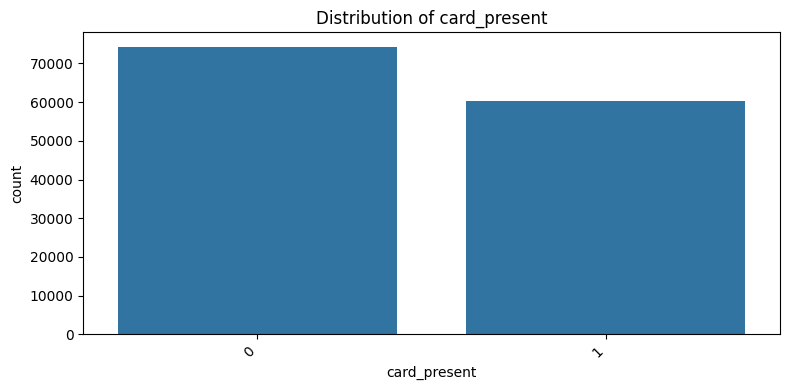

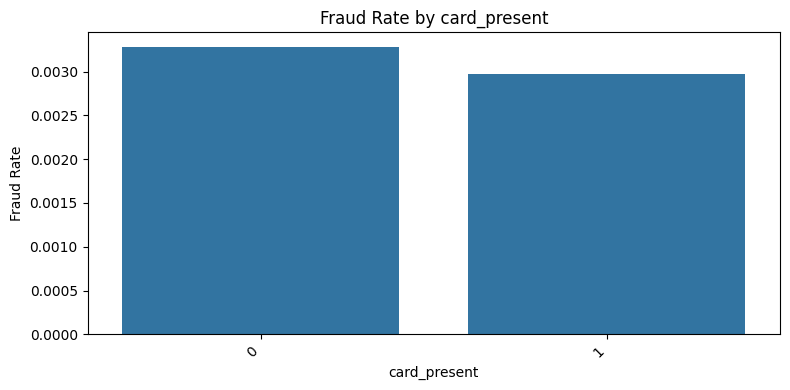

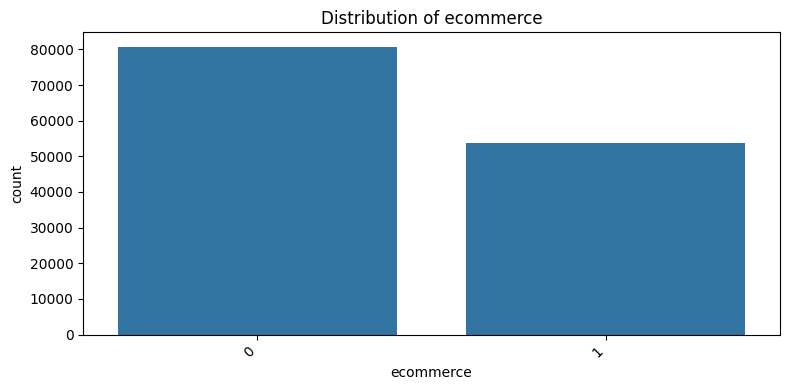

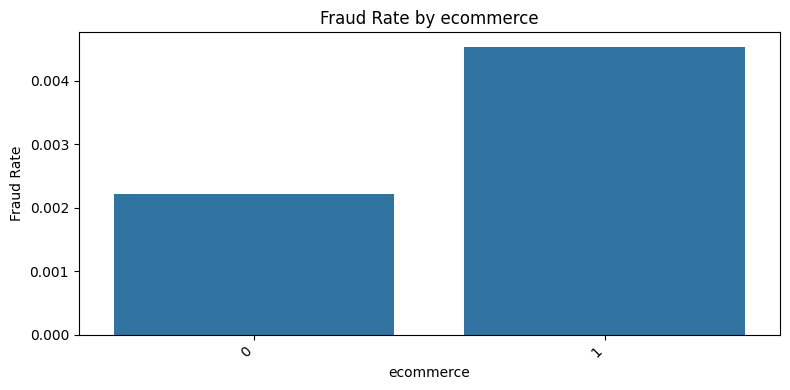

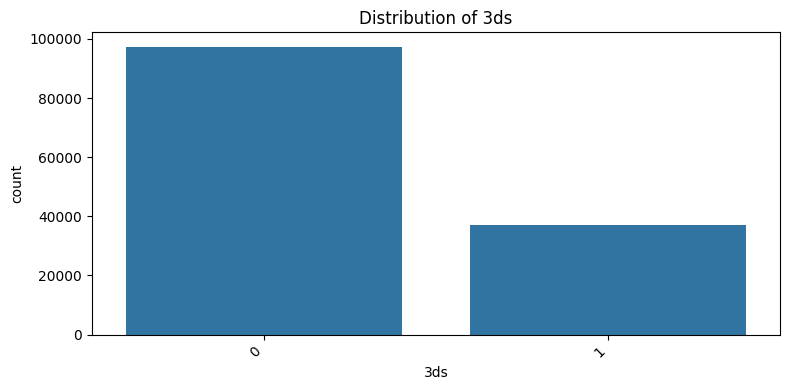

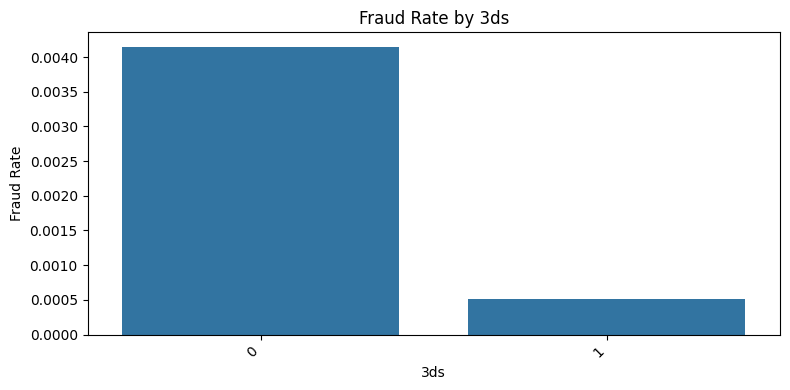

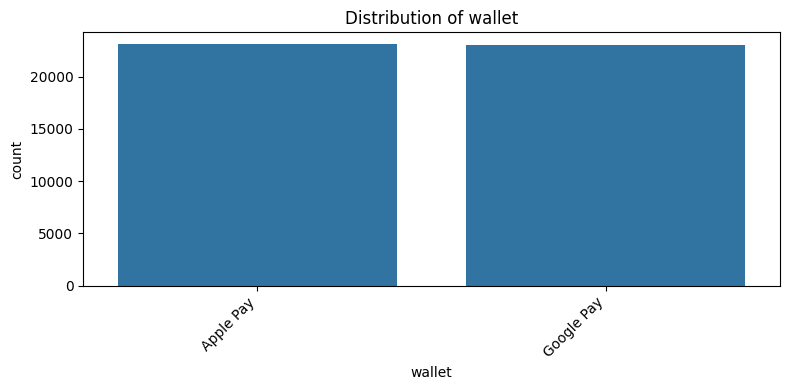

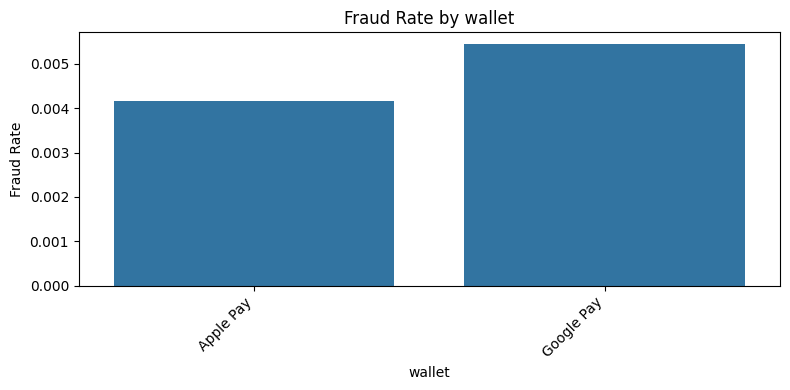

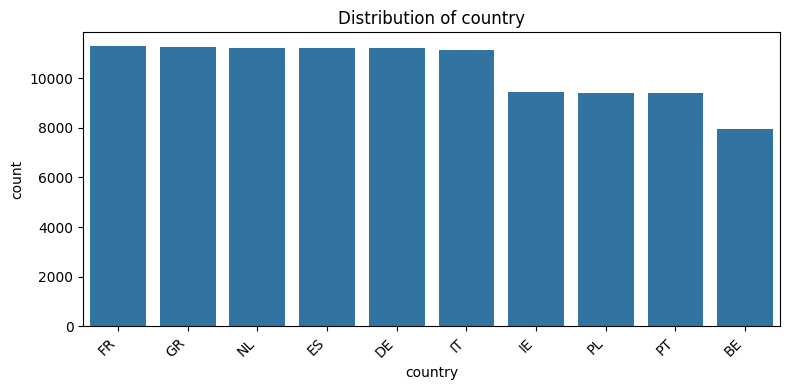

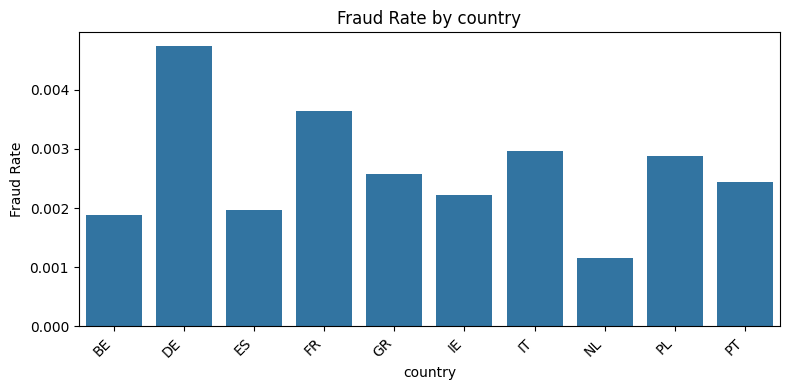

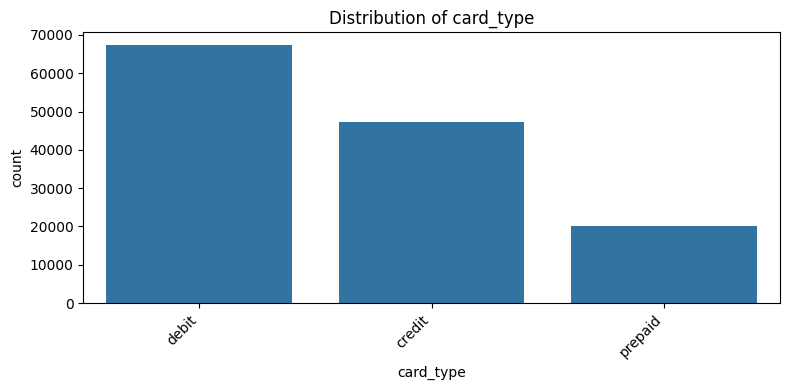

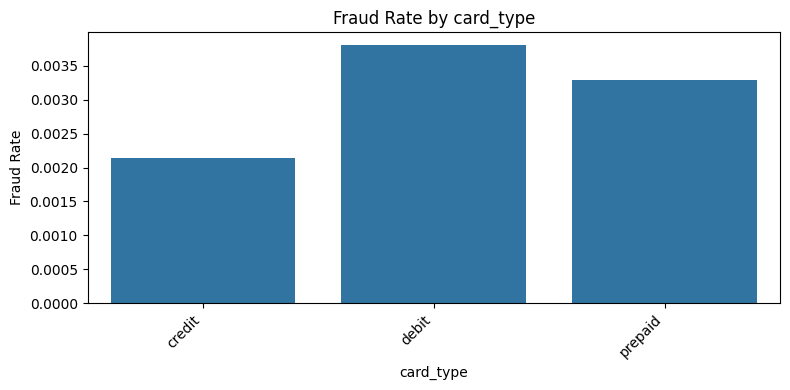

In [80]:
plot_categorical_vs_fraud(df, cat_cols=['card_present', 'ecommerce', '3ds', 'wallet', 'country', 'card_type'])

_Categorical Variables Analysis:_
- Card Present 
    - The dataset contains more CnP transactions. Fraud rate is simillar between CnP and CP transactions.
    - Even though CnP transactions represent a greater part of the total transactions and fraud rates are similar (0.33% in CnP vs 0.30% in CP transactions) there is not enough evidence by this field alone to suggest that CnP transactions are more susceptible to fraud.
- Ecommerce
    - The dataset contains more ecommerce transactions than non-ecommerce. This follows the pattern of CnP vs CP transactions (ecommerce transactions are all considered CnP transactions)
    - Ecommerce transactions have high fraud rates in direct comparison to the non-ecommerce transactions which have substantially lower. This could mean that the driving factor behind the higher fraud rates in CnP transactions is the ecommerce fraud.
- 3ds
    - Most transaction are not 3d Secure.
    - Most frauds occur in non secure transactions which is expected.
- Wallet
    - The wallet porfolio (Apple Pay, Google Pay) is split.
    - No significant difference is observed between the two portfolios. The type of wallet does not seem to be a driving factor.
- Country
    - Some countries show higher fraud rates than others. 
    - EU countries show lower fraud rates compared to Asia and US regions. There might underlying reasons such as legislation enforced by EU for safer transactions under PSD2.
- Card Type 
    - Debit cards have the most transactions, followed by credit and pre-paid cards.
    - The highest fraud rate is observed in debit card transactions. This is expected since even though these cards are tied to the bank, there can be exploited by fraudsters in very different scenarios explaining the high fraud rates. Prepaid cards have the second highest fraud rates followed by Credit Cards

### Segmentation Analysis

In this section of the EDA we perform basic analysis to get a first grasp of both Quantitative and Qualitative aspects of our dataset.

**Fraud Rate & Fraud Counts** by Segment
- Segments include:
  - Country Analysis (We examine either the country where the transaction occurs offers supportive evidence for fraud activity)
  - Ecommerce vs. non-Ecommerce (We examine either fraud is more prevelant in e-commerce transactions)
  - Card Present vs. Card Not Present (We aim to examine how CP or CnP transactions can modify amplify the risk of fraud)
  - 3ds (We examine if the EU initiative of SCA enforcement in all EU merchants can significantly reduce fraud rates and/or Amounts lost due to fraud acitivity)
  - wallet (We examine if a wallet transaction (which by law is part of SCA enforcement) can offer significant protection)
  - datetime (we examine when do fraudsters operate)

In [81]:
def print_fraud_stats(df, group_cols):
    grouped = df.groupby(group_cols)['fraud_label']
    count = grouped.count()
    fraud_sum = grouped.sum()
    fraud_rate = (fraud_sum / count).fillna(0)

    summary = pd.DataFrame({
        'Transaction Count': count,
        'Fraud Count': fraud_sum,
        'Fraud Rate (%)': (fraud_rate * 100).round(2)
    }).sort_values(by='Fraud Count', ascending=False)

    print(f"\nFraud statistics grouped by {group_cols}:\n{summary}\n")

#### Fraud

In [82]:
total_fraud_count = df['fraud_label'].sum()
print(f"Total fraud cases are: {total_fraud_count}")
print(f"The fraud rate is: {(total_fraud_count / df.shape[0]) * 100:.2f}%")

Total fraud cases are: 423
The fraud rate is: 0.31%


We report 423 Fraud Cases. About 1 in 300 transactions is fradulent.

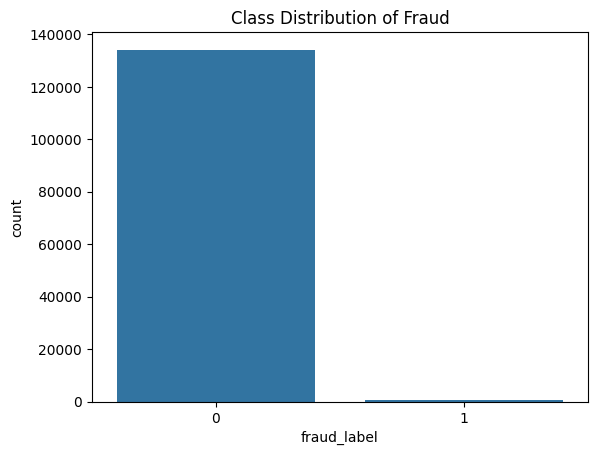

In [83]:
sns.countplot(x='fraud_label', data=df)
plt.title("Class Distribution of Fraud")
plt.show()

#### Fraud Amount

In [84]:
# calculate total fraud amount
total_fraud_amount = df[df['fraud_label'] == 1]['amount'].sum()
print(f"Total fraud amount: {total_fraud_amount}")

Total fraud amount: 46176.24


We also report ~46000EUR in fraud amount. That amount is split is 423 fraud cases.

#### Country

In [85]:
# # Country Transactional Analysis
print_fraud_stats(df, 'country')
print_fraud_stats(df, ['country', 'ecommerce'])


Fraud statistics grouped by country:
         Transaction Count  Fraud Count  Fraud Rate (%)
country                                                
US                    7514           74            0.98
DE                   11201           53            0.47
FR                   11278           41            0.36
IT                   11126           33            0.30
GR                   11249           29            0.26
PL                    9404           27            0.29
PT                    9397           23            0.24
ES                   11224           22            0.20
IE                    9454           21            0.22
PK                    5530           21            0.38
SG                    5528           19            0.34
BE                    7959           15            0.19
NL                   11229           13            0.12
CN                    5699           12            0.21
JP                    3368            8            0.24
IN        

_Worst Performers (E-commerce)_

These countries exhibit the **highest fraud rates** in e-commerce transactions:

| Rank | Country | Fraud Rate (%) | Fraud Count | Transaction Count |
|------|---------|----------------|-------------|-------------------|
| 1    | RO      | **100.00**     | 3           | 3                 |
| 2    | BG      | **100.00**     | 1           | 1                 |
| 3    | US      | 1.07           | 26          | 2419              |
| 4    | PK      | 0.88           | 18          | 2038              |
| 5    | SG      | 0.59           | 12          | 2023              |

_Insight_: **US** leads large economies in e-commerce fraud. **Romania and Bulgaria** are extreme outliers due to **very low transaction counts**.

---

_Best Performers (E-commerce)_

These countries maintain the **lowest fraud rates** in e-commerce:

| Rank | Country | Fraud Rate (%) | Fraud Count | Transaction Count |
|------|---------|----------------|-------------|-------------------|
| 1    | ES      | **0.04**       | 3           | 7002              |
| 2    | NL      | 0.19           | 8           | 4241              |
| 3    | FR      | 0.18           | 8           | 4339              |
| 4    | PT      | 0.43           | 18          | 4154              |
| 5    | IE      | 0.41           | 18          | 4348              |

_Insight_: **Spain and Netherlands** show very low fraud rates in e-commerce, suggesting effective fraud prevention systems.

---

_Regional Trends in Fraud (E-commerce)_

| Region     | Countries                          | Avg Fraud Rate (%) |
|------------|------------------------------------|---------------------|
| US         | US                                 | 1.07                |
| Asia       | PK, SG, CN, JP, IN                 | 0.59                |
| Europe     | DE, FR, IT, GR, PL, PT, ES, IE, NL, BE, RO, BG | 0.31      |

_Insight_:  
- **US remains the highest-risk** country in e-commerce fraud.  
- **Europe outperforms other regions**, benefitting from **widespread SCA adoption**.

---

_Worst Performers (Non-E-commerce)_

These countries show the highest fraud rates in non-ecommerce transactions:

| Rank | Country | Fraud Rate (%) | Fraud Count | Transaction Count |
|------|---------|----------------|-------------|-------------------|
| 1    | RO      | **100.00**     | 3           | 3                 |
| 2    | BG      | **100.00**     | 1           | 1                 |
| 3    | US      | 0.94           | 48          | 5095              |
| 4    | DE      | 0.58           | 40          | 6935              |
| 5    | FR      | 0.48           | 33          | 6939              |

_Insight_: **Small sample bias** affects Romania and Bulgaria. Among major countries, **US again ranks highest** in non-ecommerce fraud.

---

_Best Performers (Non-E-commerce)_

These countries maintain low fraud rates in non-ecommerce:

| Rank | Country | Fraud Rate (%) | Fraud Count | Transaction Count |
|------|---------|----------------|-------------|-------------------|
| 1    | BE      | **0.00**       | 0           | 4257              |
| 2    | IN      | 0.00           | 0           | 1783              |
| 3    | JP      | 0.00           | 0           | 1753              |
| 4    | ES      | 0.04           | 3           | 7002              |
| 5    | IE      | 0.06           | 3           | 5106              |

_Insight_: **Belgium, India, and Japan** show zero fraud in non-ecommerce, with **Spain and Ireland** also performing very well.

---

_Overall Country Fraud Rates (All Transactions)_

| Rank | Country | Fraud Rate (%) | Fraud Count | Transaction Count |
|------|---------|----------------|-------------|-------------------|
| 1    | RO      | **100.00**     | 3           | 3                 |
| 2    | BG      | **100.00**     | 1           | 1                 |
| 3    | US      | 0.98           | 74          | 7514              |
| 4    | PK      | 0.38           | 21          | 5530              |
| 5    | SG      | 0.34           | 19          | 5528              |
| ...  | ...     | ...            | ...         | ...               |
| 17   | NL      | 0.12           | 13          | 11229             |

_Insight_:  
- **US consistently ranks as highest fraud risk** across both e-commerce and non-ecommerce.  
- **Netherlands has the lowest overall fraud rate** among major economies.

---


In [86]:
amount_and_fraud_rate_by_country_df = df.groupby('country').agg(
    total_frauds=('fraud_label', 'sum'),
    total_transactions=('fraud_label', 'count'),
    fraud_rate=('fraud_label', lambda x: (x.sum() / len(x)) * 100),
    fraud_amount=('amount', lambda x: x[df['fraud_label'] == 1].sum()),
    fraud_amount_per_transaction=('amount', lambda x: x[df['fraud_label'] == 1].sum() / len(x[df['fraud_label'] == 1]))
).reset_index()

amount_and_fraud_rate_by_country_df.sort_index(ascending=False, inplace=True)
amount_and_fraud_rate_by_country_df

,country,total_frauds,total_transactions,fraud_rate,fraud_amount,fraud_amount_per_transaction
17,US,74,7514,0.984828,5985.82,80.889459
16,SG,19,5528,0.343705,2710.89,142.678421
15,RO,3,3,100.000000,784.88,261.626667
14,PT,23,9397,0.244759,3255.39,141.538696
13,PL,27,9404,0.287112,2619.19,97.007037
12,PK,21,5530,0.379747,2312.02,110.096190
11,NL,13,11229,0.115772,1365.07,105.005385
10,JP,8,3368,0.237530,1497.26,187.157500
9,IT,33,11126,0.296603,3518.69,106.626970
8,IN,8,3396,0.235571,1632.06,204.007500


We can see that countries that belong in Asia have higher fraud amounts than usual. US also appears to have abnormal fraud activity. This may be the result of non-3ds transactions being fraudulent. 

#### CP vs CnP Transactions

In [87]:
print_fraud_stats(df, 'card_present')


Fraud statistics grouped by card_present:
              Transaction Count  Fraud Count  Fraud Rate (%)
card_present                                                
0                         74319          244            0.33
1                         60241          179            0.30



Fraud can be observed in both CP and CnP transactions. Interestingly, CnP transactions occur more frequently showing a shift in transactional culture.

In [88]:
print_fraud_stats(df, ['country','card_present'])


Fraud statistics grouped by ['country', 'card_present']:
                      Transaction Count  Fraud Count  Fraud Rate (%)
country card_present                                                
US      1                          4422           48            1.09
DE      1                          5316           40            0.75
FR      1                          5338           33            0.62
US      0                          3092           26            0.84
PL      0                          5872           22            0.37
GR      0                          5972           20            0.33
ES      0                          5819           19            0.33
PT      0                          5733           18            0.31
PK      0                          2732           18            0.66
IE      0                          5959           18            0.30
IT      0                          5850           17            0.29
        1                          5276      

The results between CP vs CnP transactions when considering the country the transaction occurs are simillat to the ecommerce transactions. This is because of the nature of the ecommerce transaction which is by default a CnP transaction.

_Worst Performers (Card Present Transactions)_

These countries exhibit the **highest fraud rates** when the card was present:

| Rank | Country | Fraud Rate (%) | Fraud Count | Transaction Count |
|------|---------|----------------|-------------|-------------------|
| 1    | US      | **1.09**       | 48          | 4422              |
| 2    | DE      | 0.75           | 40          | 5316              |
| 3    | FR      | 0.62           | 33          | 5338              |
| 4    | SG      | 0.25           | 7           | 2836              |
| 5    | CN      | 0.07           | 2           | 2839              |

_Insight_: Even in **card-present** settings, **US, Germany, and France** show higher fraud rates, suggesting issues with physical verification or terminal security.

---

_Best Performers (Card Present Transactions)_

These countries maintain the **lowest fraud rates** in card-present transactions:

| Rank | Country | Fraud Rate (%) | Fraud Count | Transaction Count |
|------|---------|----------------|-------------|-------------------|
| 1    | BE      | **0.00**       | 0           | 2596              |
| 2    | IN      | 0.00           | 0           | 1080              |
| 3    | JP      | 0.00           | 0           | 1028              |
| 4    | NL      | 0.09           | 5           | 5339              |
| 5    | IE      | 0.09           | 3           | 3495              |

_Insight_: **Belgium, India, and Japan** show perfect card-present security, while **Netherlands and Ireland** also perform strongly.

---

_Worst Performers (Card Not Present Transactions)_

These countries exhibit the **highest fraud rates** when the card was not present:

| Rank | Country | Fraud Rate (%) | Fraud Count | Transaction Count |
|------|---------|----------------|-------------|-------------------|
| 1    | RO      | **100.00**     | 3           | 3                 |
| 2    | BG      | **100.00**     | 1           | 1                 |
| 3    | US      | 0.84           | 26          | 3092              |
| 4    | PK      | 0.66           | 18          | 2732              |
| 5    | SG      | 0.45           | 12          | 2692              |

_Insight_: **Remote transactions** are **riskier**, especially in **US and Pakistan**. Small samples skew Romania and Bulgaria's stats.

---

_Best Performers (Card Not Present Transactions)_

These countries maintain **low fraud rates** in card-not-present transactions:

| Rank | Country | Fraud Rate (%) | Fraud Count | Transaction Count |
|------|---------|----------------|-------------|-------------------|
| 1    | FR      | **0.13**       | 8           | 5940              |
| 2    | NL      | 0.14           | 8           | 5890              |
| 3    | PL      | 0.14           | 5           | 3532              |
| 4    | PT      | 0.14           | 5           | 3664              |
| 5    | ES      | 0.06           | 3           | 5405              |

_Insight_: **France, Netherlands, and Spain** maintain strong performance in **remote/card-not-present** environments, likely due to **robust digital payment controls**.

---

_Overall Trends (Card Presence)_

| Card Present | Avg Fraud Rate (%) | Notes                               |
|--------------|---------------------|-------------------------------------|
| 1 (Yes)      | **0.47**            | Higher fraud in physical settings   |
| 0 (No)       | **0.36**            | Slightly lower fraud in remote use  |

_Insight_:  
- Fraud is **marginally higher in card-present** scenarios, possibly due to **POS terminal vulnerabilities** or **in-person social engineering**.  
- However, **non-present fraud still dominates** in critical outliers like **US and PK**, highlighting the need for **multi-layer authentication** online.

---


#### Ecommerce

In [89]:
print_fraud_stats(df, 'ecommerce')


Fraud statistics grouped by ecommerce:
           Transaction Count  Fraud Count  Fraud Rate (%)
ecommerce                                                
1                      53805          244            0.45
0                      80755          179            0.22



Most fraud cases are ecommerce transactions

In [90]:
print_fraud_stats(df, ['ecommerce', '3ds'])


Fraud statistics grouped by ['ecommerce', '3ds']:
               Transaction Count  Fraud Count  Fraud Rate (%)
ecommerce 3ds                                                
1         0                19629          229            1.17
0         0                77755          175            0.23
1         1                34176           15            0.04
0         1                 3000            4            0.13



There are no ecommerce transactions where the 3ds authentication has been enforced. The fraud rate between ecommerce and non-ecommerce transactions where 3ds has not been enforced is more than double. This could indicate that ecommerce transactions are more valnurable and more easily hijacked by fraudsters. 

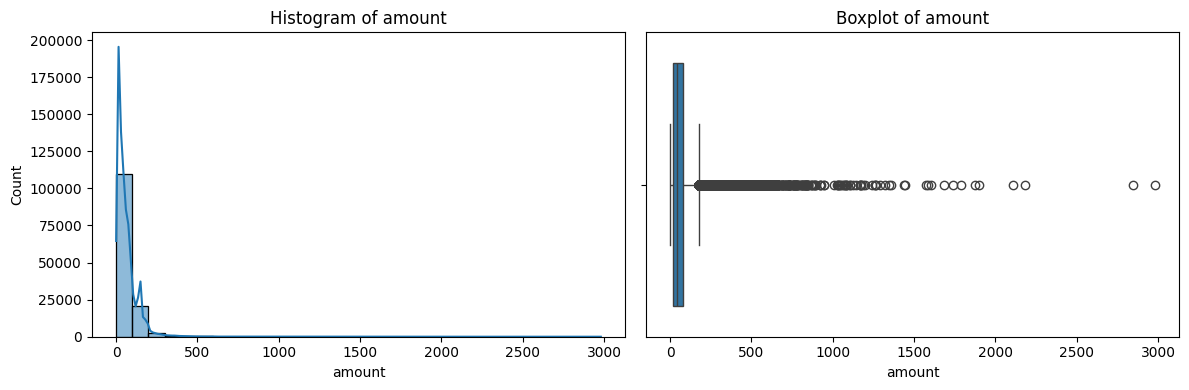

C:\Users\HA432CU\AppData\Local\Temp\ipykernel_33772\3085391368.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate = df.groupby('bin')[target_col].mean().reset_index()


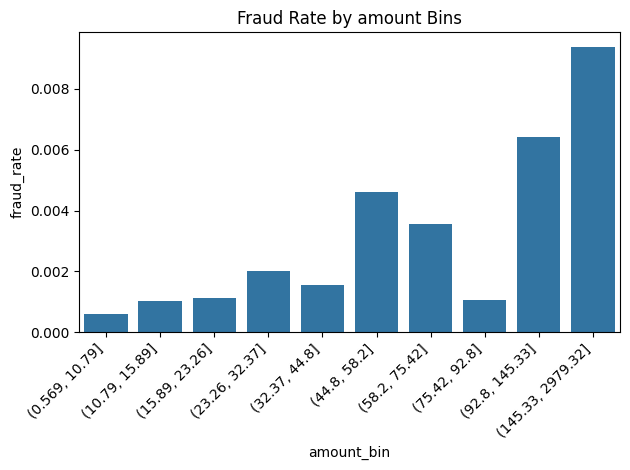

In [91]:
plot_numerical_analysis(df, num_cols=['amount'])

# int bins - mipws den valw bins

### Categorical Variable Analysis

In [92]:
def plot_categorical_vs_fraud(df, cat_cols, target_col='fraud_label', top_n=10):
    """
    Plots count and fraud rate for each categorical feature.
    """
    for col in cat_cols:

        # If high cardinality, limit to top N
        if df[col].nunique() > top_n:
            top_categories = df[col].value_counts().nlargest(top_n).index
            data = df[df[col].isin(top_categories)].copy()
        else:
            data = df.copy()

        # Countplot
        plt.figure(figsize=(8, 4))
        sns.countplot(data=data, x=col, order=data[col].value_counts().index)
        plt.title(f"Distribution of {col}")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # Fraud rate per category
        fraud_rate = data.groupby(col)[target_col].mean().reset_index()
        plt.figure(figsize=(8, 4))
        sns.barplot(data=fraud_rate, x=col, y=target_col, order=fraud_rate[col])
        plt.title(f"Fraud Rate by {col}")
        plt.ylabel("Fraud Rate")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

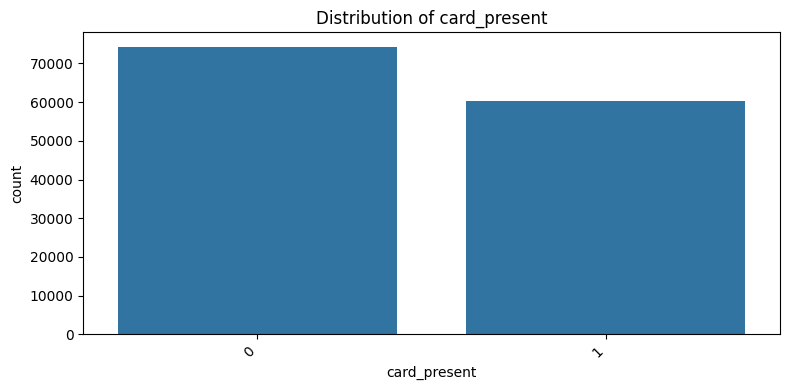

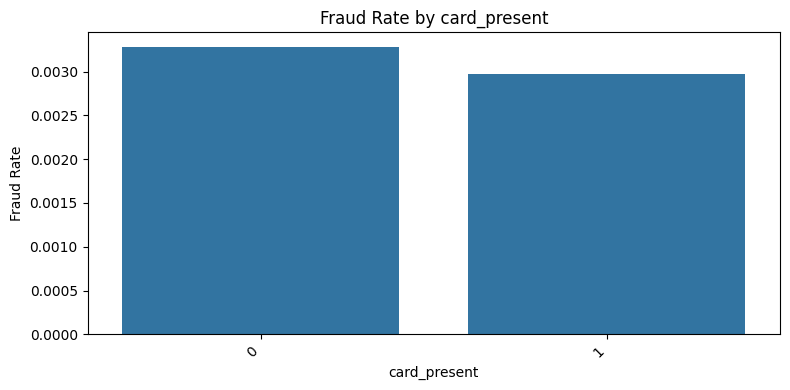

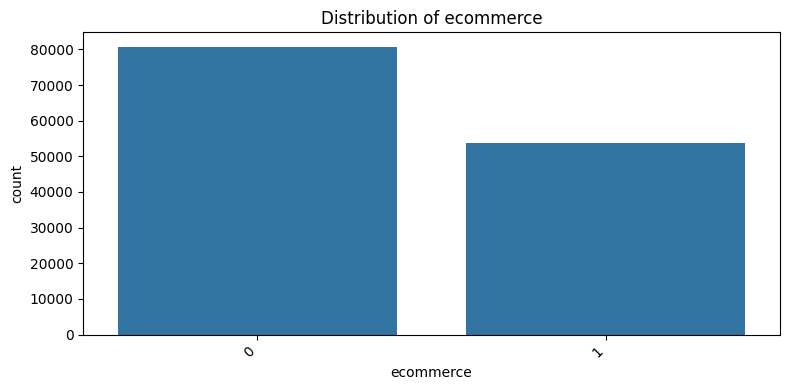

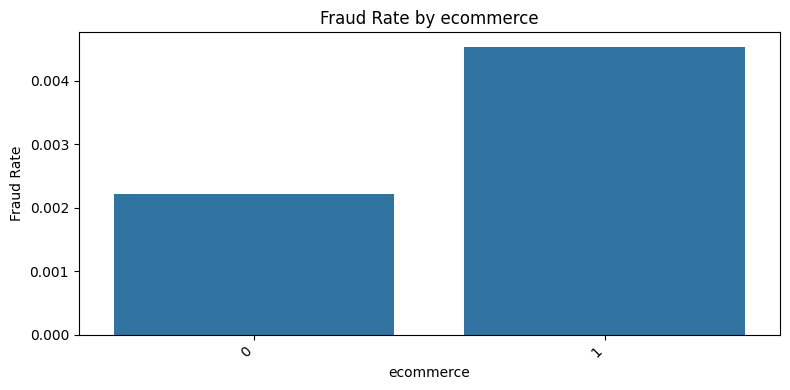

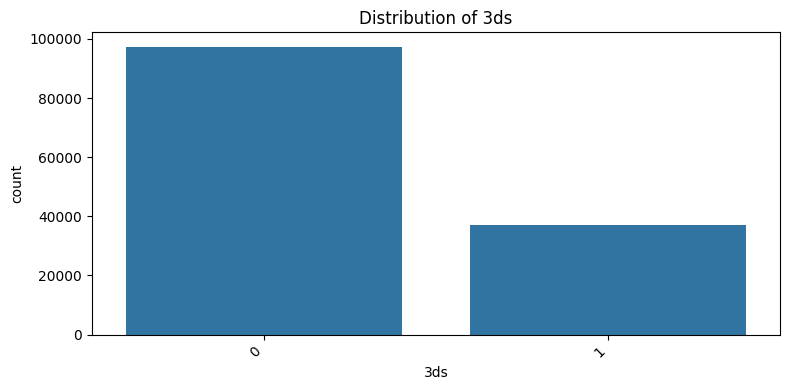

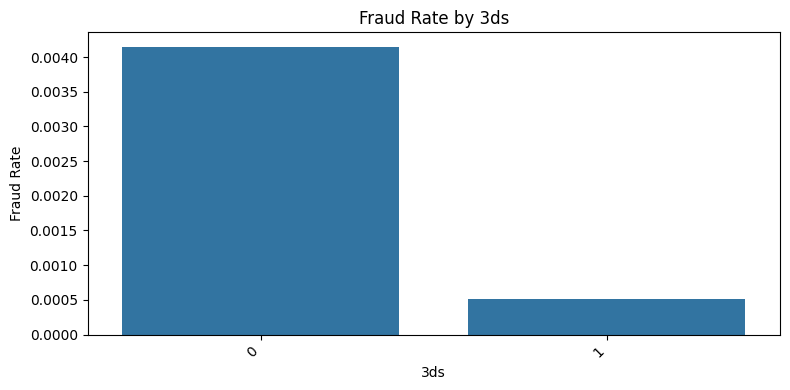

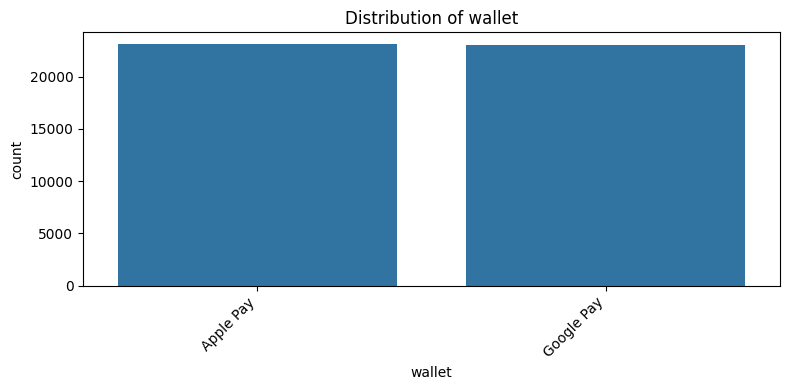

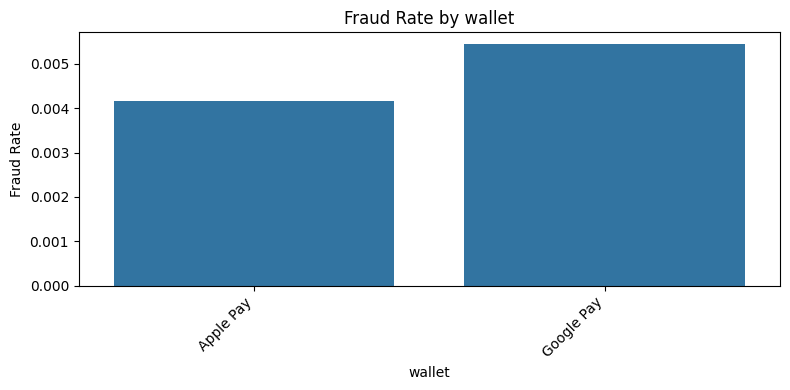

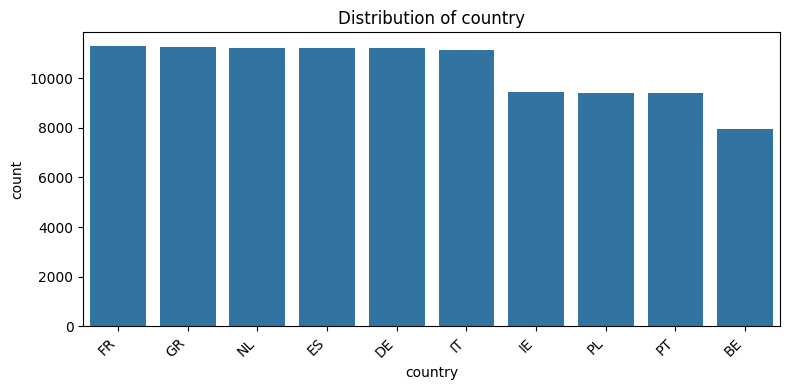

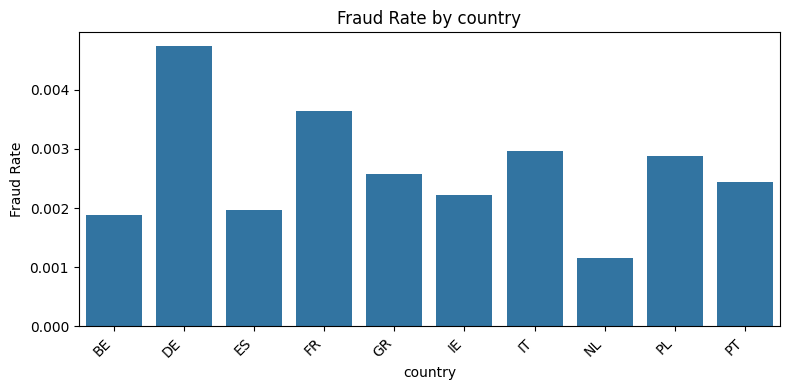

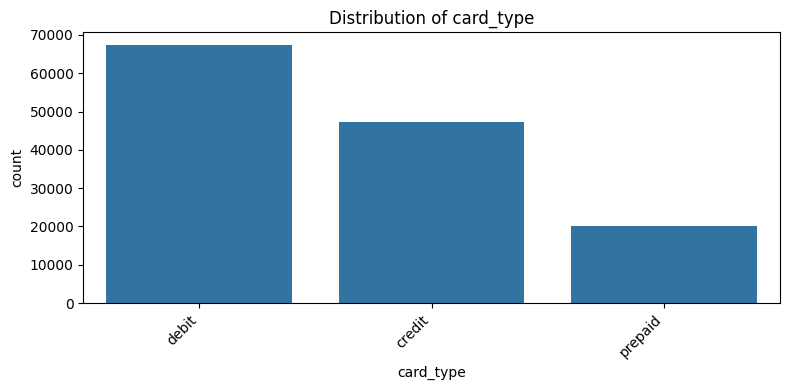

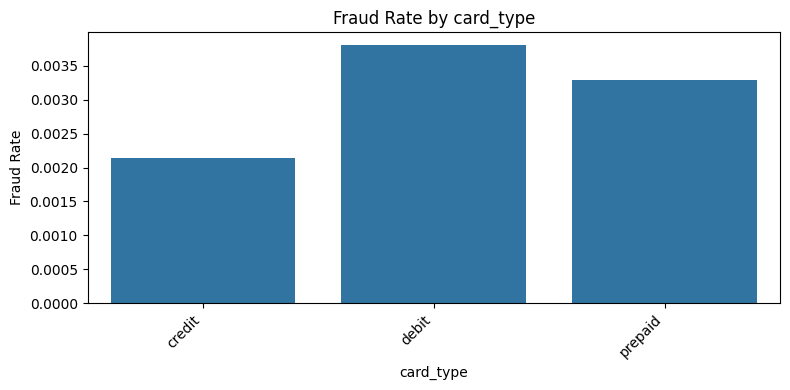

In [93]:
plot_categorical_vs_fraud(df, cat_cols=['card_present', 'ecommerce', '3ds', 'wallet', 'country', 'card_type'])

_Categorical Variables Analysis:_
- Card Present 
    - The dataset contains more CnP transactions. Fraud rate is simillar between CnP and CP transactions.
    - Even though CnP transactions represent a greater part of the total transactions and fraud rates are similar (0.33% in CnP vs 0.30% in CP transactions) there is not enough evidence by this field alone to suggest that CnP transactions are more susceptible to fraud.
- Ecommerce
    - The dataset contains more ecommerce transactions than non-ecommerce. This follows the pattern of CnP vs CP transactions (ecommerce transactions are all considered CnP transactions)
    - Ecommerce transactions have high fraud rates in direct comparison to the non-ecommerce transactions which have substantially lower. This could mean that the driving factor behind the higher fraud rates in CnP transactions is the ecommerce fraud.
- 3ds
    - Most transaction are not 3d Secure.
    - Most frauds occur in non secure transactions which is expected.
- Wallet
    - The wallet porfolio (Apple Pay, Google Pay) is split.
    - No significant difference is observed between the two portfolios. The type of wallet does not seem to be a driving factor.
- Country
    - Some countries show higher fraud rates than others. 
    - EU countries show lower fraud rates compared to Asia and US regions. There might underlying reasons such as legislation enforced by EU for safer transactions under PSD2.
- Card Type 
    - Debit cards have the most transactions, followed by credit and pre-paid cards.
    - The highest fraud rate is observed in debit card transactions. This is expected since even though these cards are tied to the bank, there can be exploited by fraudsters in very different scenarios explaining the high fraud rates. Prepaid cards have the second highest fraud rates followed by Credit Cards

### Segmentation Analysis

In this section of the EDA we perform basic analysis to get a first grasp of both Quantitative and Qualitative aspects of our dataset.

**Fraud Rate & Fraud Counts** by Segment
- Segments include:
  - Country Analysis (We examine either the country where the transaction occurs offers supportive evidence for fraud activity)
  - Ecommerce vs. non-Ecommerce (We examine either fraud is more prevelant in e-commerce transactions)
  - Card Present vs. Card Not Present (We aim to examine how CP or CnP transactions can modify amplify the risk of fraud)
  - 3ds (We examine if the EU initiative of SCA enforcement in all EU merchants can significantly reduce fraud rates and/or Amounts lost due to fraud acitivity)
  - wallet (We examine if a wallet transaction (which by law is part of SCA enforcement) can offer significant protection)
  - datetime (we examine when do fraudsters operate)

In [94]:
def print_fraud_stats(df, group_cols):
    grouped = df.groupby(group_cols)['fraud_label']
    count = grouped.count()
    fraud_sum = grouped.sum()
    fraud_rate = (fraud_sum / count).fillna(0)

    summary = pd.DataFrame({
        'Transaction Count': count,
        'Fraud Count': fraud_sum,
        'Fraud Rate (%)': (fraud_rate * 100).round(2)
    }).sort_values(by='Fraud Count', ascending=False)

    print(f"\nFraud statistics grouped by {group_cols}:\n{summary}\n")

#### Fraud

In [95]:
total_fraud_count = df['fraud_label'].sum()
print(f"Total fraud cases are: {total_fraud_count}")
print(f"The fraud rate is: {(total_fraud_count / df.shape[0]) * 100:.2f}%")

Total fraud cases are: 423
The fraud rate is: 0.31%


We report 423 Fraud Cases. About 1 in 300 transactions is fradulent.

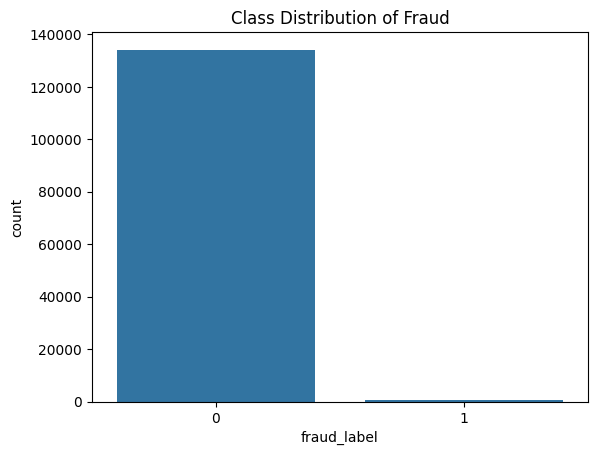

In [96]:
sns.countplot(x='fraud_label', data=df)
plt.title("Class Distribution of Fraud")
plt.show()

#### Fraud Amount

In [97]:
# calculate total fraud amount
total_fraud_amount = df[df['fraud_label'] == 1]['amount'].sum()
print(f"Total fraud amount: {total_fraud_amount}")

Total fraud amount: 46176.24


We also report ~46000EUR in fraud amount. That amount is split is 423 fraud cases.

#### Country

In [98]:
# # Country Transactional Analysis
print_fraud_stats(df, 'country')
print_fraud_stats(df, ['country', 'ecommerce'])


Fraud statistics grouped by country:
         Transaction Count  Fraud Count  Fraud Rate (%)
country                                                
US                    7514           74            0.98
DE                   11201           53            0.47
FR                   11278           41            0.36
IT                   11126           33            0.30
GR                   11249           29            0.26
PL                    9404           27            0.29
PT                    9397           23            0.24
ES                   11224           22            0.20
IE                    9454           21            0.22
PK                    5530           21            0.38
SG                    5528           19            0.34
BE                    7959           15            0.19
NL                   11229           13            0.12
CN                    5699           12            0.21
JP                    3368            8            0.24
IN        

_Worst Performers (E-commerce)_

These countries exhibit the **highest fraud rates** in e-commerce transactions:

| Rank | Country | Fraud Rate (%) | Fraud Count | Transaction Count |
|------|---------|----------------|-------------|-------------------|
| 1    | RO      | **100.00**     | 3           | 3                 |
| 2    | BG      | **100.00**     | 1           | 1                 |
| 3    | US      | 1.07           | 26          | 2419              |
| 4    | PK      | 0.88           | 18          | 2038              |
| 5    | SG      | 0.59           | 12          | 2023              |

_Insight_: **US** leads large economies in e-commerce fraud. **Romania and Bulgaria** are extreme outliers due to **very low transaction counts**.

---

_Best Performers (E-commerce)_

These countries maintain the **lowest fraud rates** in e-commerce:

| Rank | Country | Fraud Rate (%) | Fraud Count | Transaction Count |
|------|---------|----------------|-------------|-------------------|
| 1    | ES      | **0.04**       | 3           | 7002              |
| 2    | NL      | 0.19           | 8           | 4241              |
| 3    | FR      | 0.18           | 8           | 4339              |
| 4    | PT      | 0.43           | 18          | 4154              |
| 5    | IE      | 0.41           | 18          | 4348              |

_Insight_: **Spain and Netherlands** show very low fraud rates in e-commerce, suggesting effective fraud prevention systems.

---

_Regional Trends in Fraud (E-commerce)_

| Region     | Countries                          | Avg Fraud Rate (%) |
|------------|------------------------------------|---------------------|
| US         | US                                 | 1.07                |
| Asia       | PK, SG, CN, JP, IN                 | 0.59                |
| Europe     | DE, FR, IT, GR, PL, PT, ES, IE, NL, BE, RO, BG | 0.31      |

_Insight_:  
- **US remains the highest-risk** country in e-commerce fraud.  
- **Europe outperforms other regions**, benefitting from **widespread SCA adoption**.

---

_Worst Performers (Non-E-commerce)_

These countries show the highest fraud rates in non-ecommerce transactions:

| Rank | Country | Fraud Rate (%) | Fraud Count | Transaction Count |
|------|---------|----------------|-------------|-------------------|
| 1    | RO      | **100.00**     | 3           | 3                 |
| 2    | BG      | **100.00**     | 1           | 1                 |
| 3    | US      | 0.94           | 48          | 5095              |
| 4    | DE      | 0.58           | 40          | 6935              |
| 5    | FR      | 0.48           | 33          | 6939              |

_Insight_: **Small sample bias** affects Romania and Bulgaria. Among major countries, **US again ranks highest** in non-ecommerce fraud.

---

_Best Performers (Non-E-commerce)_

These countries maintain low fraud rates in non-ecommerce:

| Rank | Country | Fraud Rate (%) | Fraud Count | Transaction Count |
|------|---------|----------------|-------------|-------------------|
| 1    | BE      | **0.00**       | 0           | 4257              |
| 2    | IN      | 0.00           | 0           | 1783              |
| 3    | JP      | 0.00           | 0           | 1753              |
| 4    | ES      | 0.04           | 3           | 7002              |
| 5    | IE      | 0.06           | 3           | 5106              |

_Insight_: **Belgium, India, and Japan** show zero fraud in non-ecommerce, with **Spain and Ireland** also performing very well.

---

_Overall Country Fraud Rates (All Transactions)_

| Rank | Country | Fraud Rate (%) | Fraud Count | Transaction Count |
|------|---------|----------------|-------------|-------------------|
| 1    | RO      | **100.00**     | 3           | 3                 |
| 2    | BG      | **100.00**     | 1           | 1                 |
| 3    | US      | 0.98           | 74          | 7514              |
| 4    | PK      | 0.38           | 21          | 5530              |
| 5    | SG      | 0.34           | 19          | 5528              |
| ...  | ...     | ...            | ...         | ...               |
| 17   | NL      | 0.12           | 13          | 11229             |

_Insight_:  
- **US consistently ranks as highest fraud risk** across both e-commerce and non-ecommerce.  
- **Netherlands has the lowest overall fraud rate** among major economies.

---


In [99]:
amount_and_fraud_rate_by_country_df = df.groupby('country').agg(
    total_frauds=('fraud_label', 'sum'),
    total_transactions=('fraud_label', 'count'),
    fraud_rate=('fraud_label', lambda x: (x.sum() / len(x)) * 100),
    fraud_amount=('amount', lambda x: x[df['fraud_label'] == 1].sum()),
    fraud_amount_per_transaction=('amount', lambda x: x[df['fraud_label'] == 1].sum() / len(x[df['fraud_label'] == 1]))
).reset_index()

amount_and_fraud_rate_by_country_df.sort_index(ascending=False, inplace=True)
amount_and_fraud_rate_by_country_df

,country,total_frauds,total_transactions,fraud_rate,fraud_amount,fraud_amount_per_transaction
17,US,74,7514,0.984828,5985.82,80.889459
16,SG,19,5528,0.343705,2710.89,142.678421
15,RO,3,3,100.000000,784.88,261.626667
14,PT,23,9397,0.244759,3255.39,141.538696
13,PL,27,9404,0.287112,2619.19,97.007037
12,PK,21,5530,0.379747,2312.02,110.096190
11,NL,13,11229,0.115772,1365.07,105.005385
10,JP,8,3368,0.237530,1497.26,187.157500
9,IT,33,11126,0.296603,3518.69,106.626970
8,IN,8,3396,0.235571,1632.06,204.007500


We can see that countries that belong in Asia have higher fraud amounts than usual. US also appears to have abnormal fraud activity. This may be the result of non-3ds transactions being fraudulent. 

#### CP vs CnP Transactions

In [100]:
print_fraud_stats(df, 'card_present')


Fraud statistics grouped by card_present:
              Transaction Count  Fraud Count  Fraud Rate (%)
card_present                                                
0                         74319          244            0.33
1                         60241          179            0.30



Fraud can be observed in both CP and CnP transactions. Interestingly, CnP transactions occur more frequently showing a shift in transactional culture.

In [101]:
print_fraud_stats(df, ['country','card_present'])


Fraud statistics grouped by ['country', 'card_present']:
                      Transaction Count  Fraud Count  Fraud Rate (%)
country card_present                                                
US      1                          4422           48            1.09
DE      1                          5316           40            0.75
FR      1                          5338           33            0.62
US      0                          3092           26            0.84
PL      0                          5872           22            0.37
GR      0                          5972           20            0.33
ES      0                          5819           19            0.33
PT      0                          5733           18            0.31
PK      0                          2732           18            0.66
IE      0                          5959           18            0.30
IT      0                          5850           17            0.29
        1                          5276      

The results between CP vs CnP transactions when considering the country the transaction occurs are simillat to the ecommerce transactions. This is because of the nature of the ecommerce transaction which is by default a CnP transaction.

_Worst Performers (Card Present Transactions)_

These countries exhibit the **highest fraud rates** when the card was present:

| Rank | Country | Fraud Rate (%) | Fraud Count | Transaction Count |
|------|---------|----------------|-------------|-------------------|
| 1    | US      | **1.09**       | 48          | 4422              |
| 2    | DE      | 0.75           | 40          | 5316              |
| 3    | FR      | 0.62           | 33          | 5338              |
| 4    | SG      | 0.25           | 7           | 2836              |
| 5    | CN      | 0.07           | 2           | 2839              |

_Insight_: Even in **card-present** settings, **US, Germany, and France** show higher fraud rates, suggesting issues with physical verification or terminal security.

---

_Best Performers (Card Present Transactions)_

These countries maintain the **lowest fraud rates** in card-present transactions:

| Rank | Country | Fraud Rate (%) | Fraud Count | Transaction Count |
|------|---------|----------------|-------------|-------------------|
| 1    | BE      | **0.00**       | 0           | 2596              |
| 2    | IN      | 0.00           | 0           | 1080              |
| 3    | JP      | 0.00           | 0           | 1028              |
| 4    | NL      | 0.09           | 5           | 5339              |
| 5    | IE      | 0.09           | 3           | 3495              |

_Insight_: **Belgium, India, and Japan** show perfect card-present security, while **Netherlands and Ireland** also perform strongly.

---

_Worst Performers (Card Not Present Transactions)_

These countries exhibit the **highest fraud rates** when the card was not present:

| Rank | Country | Fraud Rate (%) | Fraud Count | Transaction Count |
|------|---------|----------------|-------------|-------------------|
| 1    | RO      | **100.00**     | 3           | 3                 |
| 2    | BG      | **100.00**     | 1           | 1                 |
| 3    | US      | 0.84           | 26          | 3092              |
| 4    | PK      | 0.66           | 18          | 2732              |
| 5    | SG      | 0.45           | 12          | 2692              |

_Insight_: **Remote transactions** are **riskier**, especially in **US and Pakistan**. Small samples skew Romania and Bulgaria's stats.

---

_Best Performers (Card Not Present Transactions)_

These countries maintain **low fraud rates** in card-not-present transactions:

| Rank | Country | Fraud Rate (%) | Fraud Count | Transaction Count |
|------|---------|----------------|-------------|-------------------|
| 1    | FR      | **0.13**       | 8           | 5940              |
| 2    | NL      | 0.14           | 8           | 5890              |
| 3    | PL      | 0.14           | 5           | 3532              |
| 4    | PT      | 0.14           | 5           | 3664              |
| 5    | ES      | 0.06           | 3           | 5405              |

_Insight_: **France, Netherlands, and Spain** maintain strong performance in **remote/card-not-present** environments, likely due to **robust digital payment controls**.

---

_Overall Trends (Card Presence)_

| Card Present | Avg Fraud Rate (%) | Notes                               |
|--------------|---------------------|-------------------------------------|
| 1 (Yes)      | **0.47**            | Higher fraud in physical settings   |
| 0 (No)       | **0.36**            | Slightly lower fraud in remote use  |

_Insight_:  
- Fraud is **marginally higher in card-present** scenarios, possibly due to **POS terminal vulnerabilities** or **in-person social engineering**.  
- However, **non-present fraud still dominates** in critical outliers like **US and PK**, highlighting the need for **multi-layer authentication** online.

---


#### Ecommerce

In [102]:
print_fraud_stats(df, 'ecommerce')


Fraud statistics grouped by ecommerce:
           Transaction Count  Fraud Count  Fraud Rate (%)
ecommerce                                                
1                      53805          244            0.45
0                      80755          179            0.22



Most fraud cases are ecommerce transactions

In [103]:
print_fraud_stats(df, ['ecommerce', '3ds'])


Fraud statistics grouped by ['ecommerce', '3ds']:
               Transaction Count  Fraud Count  Fraud Rate (%)
ecommerce 3ds                                                
1         0                19629          229            1.17
0         0                77755          175            0.23
1         1                34176           15            0.04
0         1                 3000            4            0.13



There are no ecommerce transactions where the 3ds authentication has been enforced. The fraud rate between ecommerce and non-ecommerce transactions where 3ds has not been enforced is more than double. This could indicate that ecommerce transactions are more valnurable and more easily hijacked by fraudsters. 

In [104]:
print_fraud_stats(df, ['country', 'ecommerce', '3ds'])


Fraud statistics grouped by ['country', 'ecommerce', '3ds']:
                       Transaction Count  Fraud Count  Fraud Rate (%)
country ecommerce 3ds                                                
US      0         0                 4867           47            0.97
DE      0         0                 6695           40            0.60
FR      0         0                 6701           33            0.49
US      1         0                 1385           26            1.88
PL      1         0                 1396           21            1.50
...                                  ...          ...             ...
NL      1         1                 2918            0            0.00
PT      0         1                  233            0            0.00
PL      0         1                  223            0            0.00
SG      0         1                  218            0            0.00
US      1         1                 1034            0            0.00

[63 rows x 3 columns]



_Worst Performers (No 3DS E-commerce)_

Countries with the **highest fraud rates** in **e-commerce without 3DS (3D Secure)**:

| Rank | Country | Fraud Rate (%) | Fraud Count | Transaction Count |
|------|---------|----------------|-------------|-------------------|
| 1    | Romania (RO)        | **100.00**        | 3           | 3                   |
| 2    | Bulgaria (BG)       | **100.00**        | 1           | 1                   |
| 3    | United States (US)  | **1.78**          | 20          | 1122                |
| 4    | Pakistan (PK)       | 1.94              | 16          | 826                 |
| 5    | Poland (PL)         | 1.64              | 19          | 1160                |

_Insight_:  
Fraud rates are **drastically higher** in e-commerce when 3DS is not enabled. **US, PK, and PL** are the most impacted large countries.

---

_Best Performers (With 3DS E-commerce)_

Countries with the **lowest fraud rates** in **e-commerce with 3DS**:

| Rank | Country | Fraud Rate (%) | Fraud Count | Transaction Count |
|------|---------|----------------|-------------|-------------------|
| 1    | France (FR)        | **0.00**         | 0           | 2709              |
| 2    | Netherlands (NL)   | 0.00             | 0           | 2674              |
| 3    | Italy (IT)         | 0.00             | 0           | 2573              |
| 4    | Ireland (IE)       | 0.04             | 1           | 2701              |
| 5    | Portugal (PT)      | 0.04             | 1           | 2580              |

_Insight_:  
**3DS adoption significantly reduces fraud.** Many European countries using 3DS report **zero or near-zero fraud**.

---

_3DS vs. Non-3DS Fraud (E-commerce)_

| 3DS Enabled | Transaction Count | Fraud Count | Fraud Rate (%) |
|-------------|-------------------|-------------|----------------|
| No (0)      | 16,629            | 189         | **1.14**       |
| Yes (1)     | 31,176            | 9           | **0.03**       |

_Insight_:  
**3DS reduces fraud by ~38x** in e-commerce transactions. The **presence of 3DS** is the strongest defense against online payment fraud in this dataset.

---

_3DS Adoption by Region (E-commerce Only)_

| Region   | Countries Sampled      | 3DS Fraud Rate (%) |
|----------|-------------------------|---------------------|
| US       | US                      | **1.78 (No 3DS)**   |
| Europe   | FR, NL, IT, IE, PT, BE  | **0.03 (With 3DS)** |
| Asia     | CN, PK, IN, SG, JP      | 0.12 – 1.01         |

_Insight_:  
- The **US does not use 3DS effectively**, resulting in high fraud.  
- **Europe leads** in 3DS deployment and fraud prevention.  
- **Asian countries** vary widely, with some showing room for stronger authentication protocols.

---

_Non-3DS Non-Ecommerce Transactions_

| Rank | Country | Fraud Rate (%) | Fraud Count | Transaction Count |
|------|---------|----------------|-------------|-------------------|
| 1    | US      | **0.90**       | 42          | 4651              |
| 2    | DE      | 0.59           | 38          | 6468              |
| 3    | FR      | 0.46           | 30          | 6470              |

_Insight_:  
Even in **non-ecommerce**, absence of 3DS results in measurable fraud, especially in **US and Germany**.

---


#### Wallet

In [105]:
print_fraud_stats(df, 'wallet')


Fraud statistics grouped by wallet:
            Transaction Count  Fraud Count  Fraud Rate (%)
wallet                                                    
Google Pay              22983          125            0.54
Apple Pay               23071           96            0.42



In [106]:
print_fraud_stats(df, ['card_present', 'wallet'])


Fraud statistics grouped by ['card_present', 'wallet']:
                         Transaction Count  Fraud Count  Fraud Rate (%)
card_present wallet                                                    
1            Apple Pay                8186           66            0.81
             Google Pay               7987           63            0.79
0            Google Pay              14996           62            0.41
             Apple Pay               14885           30            0.20



In [107]:
print_fraud_stats(df, ['country', 'ecommerce', '3ds', 'wallet'])


Fraud statistics grouped by ['country', 'ecommerce', '3ds', 'wallet']:
                                  Transaction Count  Fraud Count  \
country ecommerce 3ds wallet                                       
DE      0         0   Apple Pay                 442           28   
US      0         0   Google Pay                731           16   
        1         0   Google Pay                281           15   
PL      1         0   Google Pay                123           13   
DE      0         0   Google Pay                433           12   
...                                             ...          ...   
SG      0         1   Google Pay                105            0   
        1         1   Apple Pay                 503            0   
US      0         1   Apple Pay                 120            0   
        1         1   Apple Pay                 512            0   
                      Google Pay                522            0   

                                  Fraud Rat

_Worst Performers (E-commerce, No 3DS)_

These countries show the **highest fraud rates** in e-commerce when 3D Secure (3DS) is **not used**:

| Rank | Country | Fraud Rate (%) | Fraud Count | Transaction Count |
|------|---------|----------------|-------------|-------------------|
| 1    | US      | **1.88**       | 26          | 1385              |
| 2    | PL      | 1.50           | 21          | 1396              |
| 3    | GR      | 1.01           | 18          | 1778              |
| 4    | IE      | 0.98           | 16          | 1628              |
| 5    | PT      | 0.86           | 14          | 1632              |

_Insight_: Fraud is **highest where 3DS is not implemented**. The **US and Poland** are especially vulnerable in e-commerce without 3DS protection.

---

_Best Performers (E-commerce, With 3DS)_

These countries show the **lowest fraud rates** in e-commerce when 3D Secure is **used**:

| Rank | Country | Fraud Rate (%) | Fraud Count | Transaction Count |
|------|---------|----------------|-------------|-------------------|
| 1    | US      | **0.00**       | 0           | 1034              |
| 2    | NL      | 0.00           | 0           | 2918              |
| 3    | PT      | 0.00           | 0           | 233               |
| 4    | PL      | 0.00           | 0           | 223               |
| 5    | SG      | 0.00           | 0           | 218               |

_Insight_: **3DS implementation completely eliminates fraud** in these samples. Even high-risk countries like the **US** report **0% fraud** when 3DS is active.

---

_Worst Performers (Non-E-commerce, No 3DS)_

These are **non-ecommerce** transactions **without 3DS** with the highest fraud rates:

| Rank | Country | Fraud Rate (%) | Fraud Count | Transaction Count |
|------|---------|----------------|-------------|-------------------|
| 1    | RO      | **100.00**     | 3           | 3                 |
| 2    | BG      | 100.00         | 1           | 1                 |
| 3    | US      | 0.97           | 47          | 4867              |
| 4    | DE      | 0.60           | 40          | 6695              |
| 5    | FR      | 0.49           | 33          | 6701              |

_Insight_: **Non-ecommerce fraud without 3DS** is also high, especially in the **US**, **Germany**, and **France**. **Eastern Europe results** are **distorted by small samples**.

---

_Fraud Rate Comparison: With vs Without 3DS_

| Scenario              | Avg Fraud Rate (%) | Notes                                        |
|-----------------------|---------------------|----------------------------------------------|
| E-commerce + No 3DS   | **0.86**            | High risk across multiple countries          |
| E-commerce + 3DS      | **~0.00**           | Fraud nearly eliminated                      |
| Non-ecommerce + No 3DS| 0.69                | Still vulnerable without SCA                 |

_Insight_:  
- **3DS is highly effective** in eliminating e-commerce fraud.  
- **Most fraud occurs in the absence of 3DS**, supporting **mandated 3DS adoption** across payment channels.

---


#### Card Type

In [108]:
print_fraud_stats(df, 'card_type')


Fraud statistics grouped by card_type:
           Transaction Count  Fraud Count  Fraud Rate (%)
card_type                                                
debit                  67308          256            0.38
credit                 47164          101            0.21
prepaid                20088           66            0.33



In [109]:
print_fraud_stats(df, ['card_type', 'ecommerce'])


Fraud statistics grouped by ['card_type', 'ecommerce']:
                     Transaction Count  Fraud Count  Fraud Rate (%)
card_type ecommerce                                                
debit     0                      43344          153            0.35
          1                      23964          103            0.43
credit    1                      15858           75            0.47
prepaid   1                      13983           66            0.47
credit    0                      31306           26            0.08
prepaid   0                       6105            0            0.00



_Worst Performers by Card Type (E-commerce)_

These card types show the **highest fraud rates** in e-commerce transactions:

| Rank | Card Type | Fraud Rate (%) | Fraud Count | Transaction Count |
|------|-----------|----------------|-------------|-------------------|
| 1    | credit    | **0.47**       | 75          | 15858             |
| 2    | prepaid   | 0.47           | 66          | 13983             |
| 3    | debit     | 0.43           | 103         | 23964             |

_Insight_: **Credit and prepaid cards** are **most vulnerable in e-commerce**, likely due to **weaker user authentication** or **lack of SCA/3DS** in some cases.

---

_Best Performers by Card Type (E-commerce)_

| Rank | Card Type | Fraud Rate (%) | Fraud Count | Transaction Count |
|------|-----------|----------------|-------------|-------------------|
| 1    | prepaid   | **0.00**       | 0           | 6105              |
| 2    | credit    | 0.08           | 26          | 31306             |
| 3    | debit     | 0.35           | 153         | 43344             |

_Insight_:  
- **Prepaid cards in non-ecommerce** are completely fraud-free in this sample.  
- **Credit cards** show **much lower fraud in-store (0.08%)** than online (0.47%), highlighting the **added risk of remote usage**.

---

_Fraud Trends by Card Type and Channel_

| Card Type | Channel      | Fraud Rate (%) |
|-----------|--------------|----------------|
| Credit    | E-commerce   | **0.47**        |
| Prepaid   | E-commerce   | 0.47            |
| Debit     | E-commerce   | 0.43            |
| Debit     | Non-Ecom     | 0.35            |
| Credit    | Non-Ecom     | 0.08            |
| Prepaid   | Non-Ecom     | **0.00**        |

_Insight_:  
- **E-commerce increases fraud risk** across all card types.  
- **Non-ecommerce prepaid usage is safest**, while **credit cards** are safest for **physical transactions**.

---


#### Datetime

In [110]:
# Function to assign hour range directly
def assign_hour_range(dt):
    hour = dt.hour
    if 0 <= hour < 4:
        return "00:00–04:00"
    elif 4 <= hour < 8:
        return "04:00–08:00"
    elif 8 <= hour < 12:
        return "08:00–12:00"
    elif 12 <= hour < 16:
        return "12:00–16:00"
    elif 16 <= hour < 20:
        return "16:00–20:00"
    else:
        return "20:00–00:00"

In [111]:
# Apply function
df['hour_range'] = df['datetime'].apply(assign_hour_range)

# Group by hour range and sum frauds
fraud_counts = df.groupby('hour_range')['fraud_label'].sum().reset_index()
fraud_counts.columns = ['Hour Range', 'Fraud Cases']

# Sort by correct hour order
hour_order = ["00:00–04:00", "04:00–08:00", "08:00–12:00", "12:00–16:00", "16:00–20:00", "20:00–00:00"]
fraud_counts['Hour Range'] = pd.Categorical(fraud_counts['Hour Range'], categories=hour_order, ordered=True)
fraud_counts = fraud_counts.sort_values('Hour Range')

# Display
print(fraud_counts)

    Hour Range  Fraud Cases
0  00:00–04:00          135
1  04:00–08:00           29
2  08:00–12:00          115
3  12:00–16:00           86
4  16:00–20:00           28
5  20:00–00:00           30


In [112]:
def plot_time_based_analysis(df, datetime_col='datetime', target_col='fraud_label'):
    """
    Extracts time-based features and plots fraud trends.
    """
    df['hour'] = df[datetime_col].dt.hour
    df['weekday'] = df[datetime_col].dt.day_name()
    df['day'] = df[datetime_col].dt.day
    df['month'] = df[datetime_col].dt.month

    # Fraud Rate by Hour
    hourly = df.groupby('hour')[target_col].mean()
    plt.figure(figsize=(8, 4))
    sns.lineplot(x=hourly.index, y=hourly.values)
    plt.title("Fraud Rate by Hour of Day")
    plt.xlabel("Hour")
    plt.ylabel("Fraud Rate")
    plt.grid(True)
    plt.show()

    # Fraud Rate by Weekday
    weekday = df.groupby('weekday')[target_col].mean()
    ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekday = weekday.reindex(ordered_days)
    plt.figure(figsize=(8, 4))
    sns.barplot(x=weekday.index, y=weekday.values)
    plt.title("Fraud Rate by Day of Week")
    plt.xticks(rotation=45)
    plt.ylabel("Fraud Rate")
    plt.tight_layout()
    plt.show()


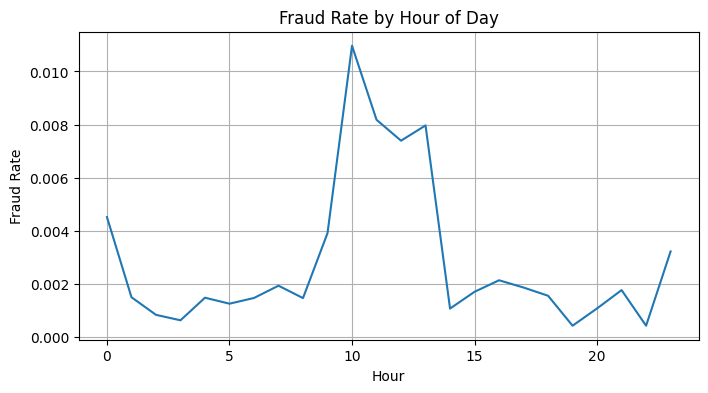

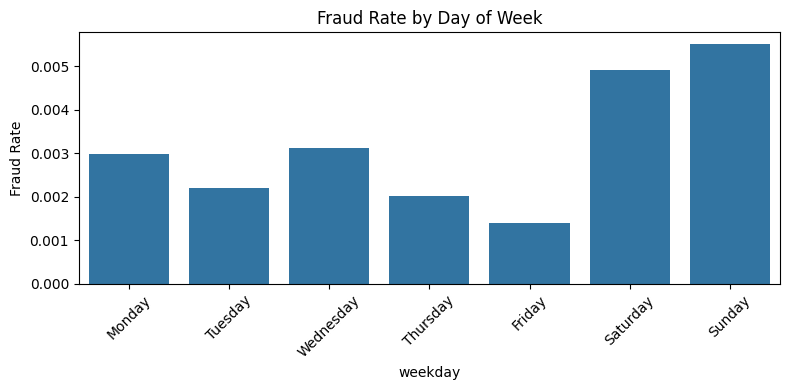

In [113]:
plot_time_based_analysis(df, datetime_col='datetime')

## Feature Engineering

In this section we will create  columns that will help us during the Rule Creation (Next Section) and the Modelling Section

_Total ID (string):_ This new column is the concatenation of the Customer ID and the Masked Pan which will help us track down and monitor potential fraud. 
The reasons are:
- A customer may have two or more pans under his name and since pan is mostly masked for data confidentiality (in our case real world simulation) we need to tie each customer to a unique masked pan
- Fraud occurs in the card level and in almost every fraud case the fraudster has not taken hold of the online banking of the customer. (Such a case could result to massive fraud which is part of ML schemes i.e. Massive Amounts transffered between different bank accounts.)

In [114]:
df['total_id'] = df['customer_id'] + ' - ' + df['masked_pan']

In the previous section we also created the following columns for a deep dive into fraud behavior through time
- hour_range	
- hour	
- weekday	
- day	
- month	

_Number of Transactions Abroad (int):_ This new column calculates the cumulative sum of transactions abroad.

In [115]:
# Sort by datetime to ensure correct ordering
df = df.sort_values(['total_id', 'datetime'])

# Define abroad transaction (not GR)
df['is_abroad'] = df['country'] != 'GR'

# Use cumsum within each total_id to get row_number-like count of abroad trx
df['number_of_abroad_trx'] = (
    df.groupby('total_id')['is_abroad']
    .cumsum()
)

# Optional cleanup
df.drop(columns=['is_abroad'], inplace=True)

_Number of Wallet Transactions (int):_ This new column calculates the cumulative sum of wallet transactions

_Region:_ In this column we categorize each country to each class.

In [116]:
iso_region_map = {
    'IE': 'Europe',
    'IT': 'Europe',
    'BE': 'Europe',
    'PK': 'Asia',
    'DE': 'Europe',
    'GR': 'Europe',
    'PL': 'Europe',
    'PT': 'Europe',
    'ES': 'Europe',
    'SG': 'Asia',
    'CN': 'Asia',
    'NL': 'Europe',
    'JP': 'Asia',
    'FR': 'Europe',
    'IN': 'Asia',
    'US': 'North America',
    'RO': 'Europe',
    'BG': 'Europe',
}

# Add region column to DataFrame
df['region'] = df['country'].map(iso_region_map)

_is_wallet:_ In this column we create a bianry flag of 1s and 0s that shows is a transaction wallet or not. We will use this column for now on forth.

In [117]:
df['is_wallet'] = df['wallet'].notnull().astype(int)

In [118]:
wallet_df = df[df['is_wallet'] == 1]
wallet_df_amount = wallet_df[wallet_df['fraud_label'] == 1]['amount'].sum()
wallet_df_fraud_cases = wallet_df[wallet_df['fraud_label'] == 1].fraud_label.count()
print(f"The total fraud amount for wallet transactions is: {round(wallet_df_amount,2)}. The total fraud cases are: {round(wallet_df_fraud_cases, 2)} and the avg fraud amount is {round(wallet_df_amount/wallet_df_fraud_cases,2)}")

The total fraud amount for wallet transactions is: 14307.06. The total fraud cases are: 221 and the avg fraud amount is 64.74


In [119]:
# Sort by datetime to ensure correct ordering
df = df.sort_values(['total_id', 'datetime'])

# Define abroad transaction (not GR)
df['is_wallet_trx'] = df['is_wallet'] == 1

# Use cumsum within each total_id to get row_number-like count of abroad trx
df['number_of_wallet_trx'] = (
    df.groupby('total_id')['is_wallet_trx']
    .cumsum()
)

# Optional cleanup
df.drop(columns=['is_wallet_trx'], inplace=True)

_time_diff:_ This column will track the time passed between transactions

In [120]:
df = df.sort_values(by=['total_id', 'datetime'])

df['time_diff'] = df.groupby('total_id')['datetime'].diff().dt.total_seconds()

In [ ]:
df.to_csv("data_processed.csv", date_format='%Y-%m-%d %H:%M:%S', index=False)